In [1]:
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster

<span style="color: rgb(0, 128, 0); font-family: SFMono-Regular, Consolas, &quot;Liberation Mono&quot;, Menlo, Courier, monospace; white-space: pre;"><b style="">Connect to DB and select data</b></span>

In [4]:
# Connection string to connect to SQL Server named instance.
conn_str = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
"Server=DESKTOP-ATBQKLU;"
"Database=tpcxbb_1gb;"
"Trusted_Connection=yes;")

In [6]:
input_query = '''SELECT
ss_customer_sk AS customer,
ROUND(COALESCE(returns_count / NULLIF(1.0*orders_count, 0), 0), 7) AS orderRatio,
ROUND(COALESCE(returns_items / NULLIF(1.0*orders_items, 0), 0), 7) AS itemsRatio,
ROUND(COALESCE(returns_money / NULLIF(1.0*orders_money, 0), 0), 7) AS monetaryRatio,
COALESCE(returns_count, 0) AS frequency
FROM
(
  SELECT
    ss_customer_sk,
    -- return order ratio
    COUNT(distinct(ss_ticket_number)) AS orders_count,
    -- return ss_item_sk ratio
    COUNT(ss_item_sk) AS orders_items,
    -- return monetary amount ratio
    SUM( ss_net_paid ) AS orders_money
  FROM store_sales s
  GROUP BY ss_customer_sk
) orders
LEFT OUTER JOIN
(
  SELECT
    sr_customer_sk,
    -- return order ratio
    count(distinct(sr_ticket_number)) as returns_count,
    -- return ss_item_sk ratio
    COUNT(sr_item_sk) as returns_items,
    -- return monetary amount ratio
    SUM( sr_return_amt ) AS returns_money
FROM store_returns
GROUP BY sr_customer_sk ) returned ON ss_customer_sk=sr_customer_sk'''


# Define the columns we wish to import.
column_info = {
    "customer": {"type": "integer"},
    "orderRatio": {"type": "integer"},
    "itemsRatio": {"type": "integer"},
    "frequency": {"type": "integer"}
}

In [8]:
customer_data = pd.read_sql(input_query, conn_str)

In [9]:
print("Data frame:", customer_data.head(n=5))

Data frame:    customer  orderRatio  itemsRatio  monetaryRatio  frequency
0     29727    0.000000    0.000000       0.000000          0
1     97643    0.068182    0.078176       0.037034          3
2     57247    0.000000    0.000000       0.000000          0
3     32549    0.086957    0.068657       0.031281          4
4      2040    0.000000    0.000000       0.000000          0


<span style="color: rgb(0, 128, 0); font-family: SFMono-Regular, Consolas, &quot;Liberation Mono&quot;, Menlo, Courier, monospace; white-space: pre; background-color: rgb(242, 242, 242);"><b>Determine number of clusters using the Elbow method</b></span>

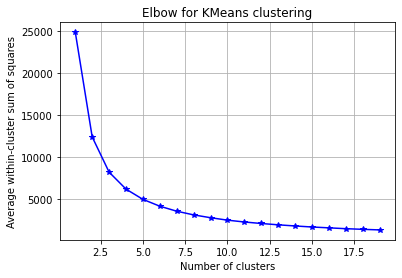

In [10]:
cdata = customer_data
K = range(1, 20)
KM = (sk_cluster.KMeans(n_clusters=k).fit(cdata) for k in K)
centroids = (k.cluster_centers_ for k in KM)

D_k = (sci_distance.cdist(cdata, cent, 'euclidean') for cent in centroids)
dist = (np.min(D, axis=1) for D in D_k)
avgWithinSS = [sum(d) / cdata.shape[0] for d in dist]
plt.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

<span style="color: rgb(0, 128, 0); font-family: SFMono-Regular, Consolas, &quot;Liberation Mono&quot;, Menlo, Courier, monospace; white-space: pre; background-color: rgb(242, 242, 242);"><b>Perform clustering using Kmeans</b></span>

In [11]:
# It looks like k=4 is a good number to use based on the elbow graph.
n_clusters = 4

means_cluster = sk_cluster.KMeans(n_clusters=n_clusters, random_state=111)
columns = ["orderRatio", "itemsRatio", "monetaryRatio", "frequency"]
est = means_cluster.fit(customer_data[columns])
clusters = est.labels_
customer_data['cluster'] = clusters

# Print some data about the clusters:

# For each cluster, count the members.
for c in range(n_clusters):
    cluster_members=customer_data[customer_data['cluster'] == c][:]
    print('Cluster{}(n={}):'.format(c, len(cluster_members)))
    print('-'* 17)
print(customer_data.groupby(['cluster']).mean())

Cluster0(n=31675):
-----------------
Cluster1(n=4989):
-----------------
Cluster2(n=1):
-----------------
Cluster3(n=671):
-----------------
             customer  orderRatio  itemsRatio  monetaryRatio  frequency
cluster                                                                
0        50854.809882    0.000000    0.000000       0.000000   0.000000
1        51332.535779    0.721604    0.453365       0.307721   1.097815
2        57044.000000    1.000000    2.000000     108.719154   1.000000
3        48516.023845    0.136277    0.078346       0.044497   4.271237
